In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [2]:
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ProgressBar
from pytorch_lightning.callbacks import Callback


import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
import logging
import matplotlib.pyplot as plt


In [3]:
torch.set_float32_matmul_precision('medium') # Or 'high'

In [4]:
Args = type('Args', (object,), {})
args = Args()

args.file = 'data/libxml2_train.pkl'
args.inputs = 357
args.outputs = 1
args.patience = 5
args.min_delta = 0.001
args.val_size = 0.2
args.batch_size = 128
args.max_epochs = 5000

In [5]:
class RuftModel(pl.LightningModule):
    def __init__(self, input_size, output_size, hidden_size=128, dropout=0.5):
        super().__init__()
        self.layer = nn.Linear(input_size, hidden_size)
        self.hidden = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(dropout)

        #self.sigmoid = nn.Sigmoid() 
        
    def forward(self, x):
        x = self.layer(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.hidden(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output(x)
        #x = self.sigmoid(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch  
        y_hat = self(x)
        loss = nn.BCEWithLogitsLoss()(y_hat.view(-1), y.type_as(y_hat).view(-1))  # Adjusting shapes
        self.log('loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        return self.training_step(batch, batch_idx)
    
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = nn.BCEWithLogitsLoss()(y_hat.view(-1), y.type_as(y_hat).view(-1))
        self.log('val_loss', val_loss)
        
        return val_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [6]:
class CustomProgressBar(ProgressBar):
    def __init__(self):
        super().__init__()
        self.training_loss = []
        self.validation_loss = []
    
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        super().on_train_batch_end(trainer, pl_module, outputs, batch, batch_idx)

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        pass
    
    def on_validation_epoch_end(self, trainer, pl_module):
        loss_txt = "N/A"
        val_loss_txt = "N/A"
        loss = trainer.logged_metrics.get('loss')
        val_loss = trainer.logged_metrics.get('val_loss')
        
        if loss is not None: 
            loss_txt = f"{loss:.4f}"
            self.training_loss.append(loss.cpu())
            
        if val_loss is not None: 
            val_loss_txt = f"{val_loss:.4f}"
            self.validation_loss.append(val_loss.cpu())    
        
        print(f'Epoch {trainer.current_epoch + 1}: loss / val_loss = {loss_txt} / {val_loss_txt}')



In [7]:
class ResourceDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float)
        self.targets = torch.tensor(targets, dtype=torch.float)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]


In [8]:
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=args.min_delta,
    patience=args.patience,
    verbose=False,
    mode='min'
)

In [9]:
data = pd.read_pickle(args.file)  
X = data.iloc[:, :-1].values
y = data.iloc[:, -1:].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=args.val_size)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [10]:
train_dataset = ResourceDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=10, shuffle=True)
val_dataset = ResourceDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=10)

In [11]:
model = RuftModel(args.inputs, args.outputs)

progress_bar = CustomProgressBar()

trainer = pl.Trainer(
    max_epochs=args.max_epochs,
    callbacks=[early_stop_callback, progress_bar],
    logger=True
)

startLoss = trainer.test(model, train_dataloader, verbose=False)[0]['loss']
progress_bar.training_loss.append(startLoss) # Seed the metrics with the initial loss

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023-11-17 13:07:43.956567: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 13:07:43.956593: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 13:07:43.956608: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


In [12]:
trainer.fit(model, train_dataloader, val_dataloader);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | layer   | Linear  | 45.8 K
1 | hidden  | Linear  | 16.5 K
2 | output  | Linear  | 129   
3 | relu    | ReLU    | 0     
4 | dropout | Dropout | 0     
------------------------------------
62.5 K    Trainable params
0         Non-trainable params
62.5 K    Total params
0.250     Total estimated model params size (MB)


Epoch 1: loss / val_loss = N/A / 0.6893
Epoch 1: loss / val_loss = 0.2175 / 0.0077
Epoch 2: loss / val_loss = 0.0045 / 0.0046
Epoch 3: loss / val_loss = 0.0000 / 0.0042
Epoch 4: loss / val_loss = 0.0002 / 0.0040
Epoch 5: loss / val_loss = 0.0009 / 0.0036
Epoch 6: loss / val_loss = 0.0001 / 0.0034
Epoch 7: loss / val_loss = 0.0001 / 0.0032
Epoch 8: loss / val_loss = 0.0006 / 0.0031
Epoch 9: loss / val_loss = 0.0031 / 0.0033
Epoch 10: loss / val_loss = 0.0000 / 0.0029
Epoch 11: loss / val_loss = 0.0002 / 0.0036


Glyph 9 (	) missing from current font.
Glyph 9 (	) missing from current font.


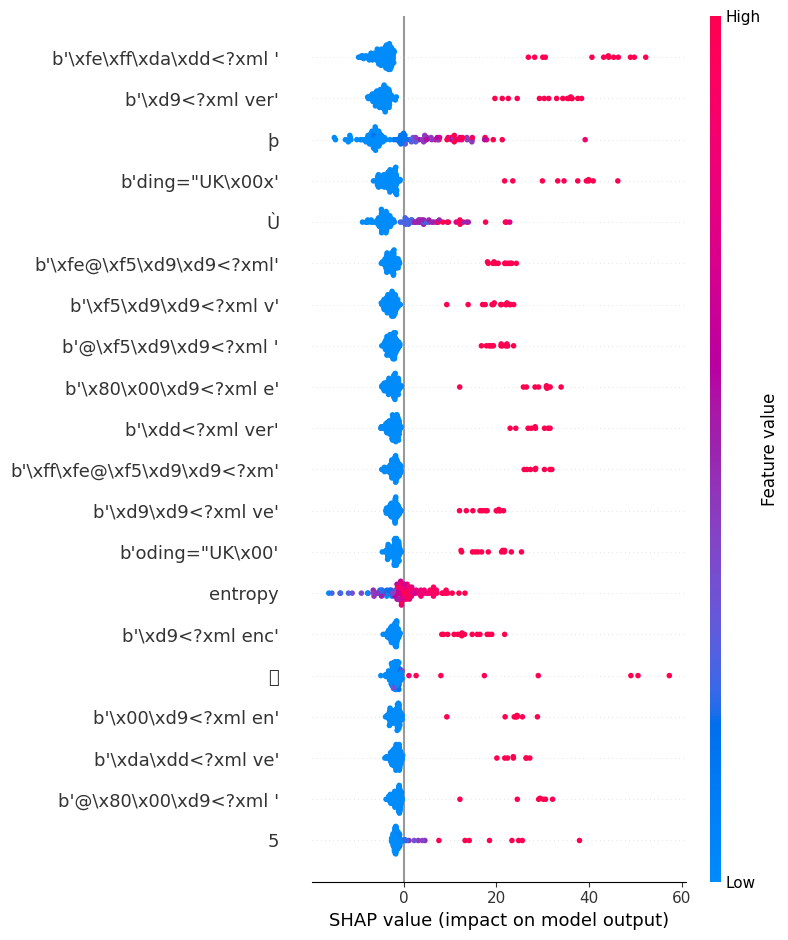

In [13]:
data_for_explanation = next(iter(val_dataloader))
features, _ = data_for_explanation

explainer = shap.GradientExplainer(model, features)
shap_values = explainer.shap_values(features)
shap.summary_plot(shap_values, features, feature_names=list(data.columns))

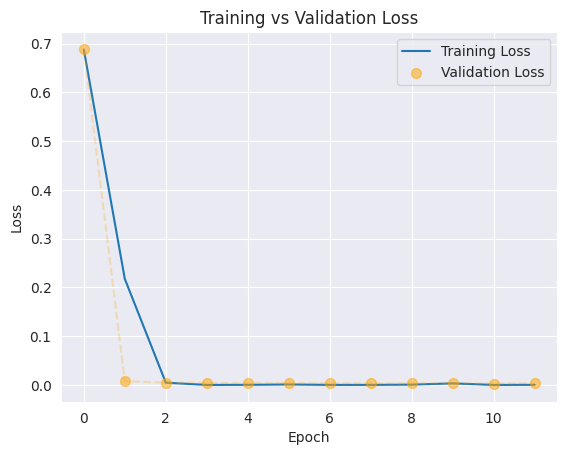

In [19]:
import seaborn as sns
sns.set_style("darkgrid")
plt.plot(progress_bar.training_loss, label='Training Loss', zorder=1)
#plt.plot(progress_bar.validation_loss, label='Validation Loss', linestyle=(0, (1, 10)))
plt.scatter( range(len(progress_bar.validation_loss)), progress_bar.validation_loss, 
             s=50, alpha=0.5, c='orange', zorder=2)
plt.plot(progress_bar.validation_loss, label='Validation Loss', c='orange', linestyle='dashed', alpha=0.25)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()